We need a bunch of packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree


This is data on pollution levels in a certain city. pm25 is pa measurement of a certain pollutant, so higher values is bad.

In [ ]:
pm25 = pd.read_csv("https://richardson.byu.edu/220/pm25.csv").iloc[0:1000,:]
pm25

,year,month,day,hour,pm25,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,2010,Jan,2,0,129,-16,-4,1020.0,SE,1.79,0,0
1,2010,Jan,2,10,140,-7,-5,1026.0,SE,17.43,1,0
2,2010,Jan,2,20,154,-7,-5,1028.0,SE,46.04,0,0
3,2010,Jan,3,6,91,-10,-8,1024.0,SE,80.90,10,0
4,2010,Jan,3,16,86,-11,-9,1020.0,SE,124.71,22,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,2011,Mar,26,16,29,-13,15,1024.0,cv,5.81,0,0
996,2011,Mar,27,2,20,-15,8,1026.0,NW,44.26,0,0
997,2011,Mar,27,12,29,-13,16,1024.0,NW,111.32,0,0
998,2011,Mar,27,22,22,-5,9,1024.0,SE,4.92,0,0


Looks like we may need to take a log transformation of the target variable.

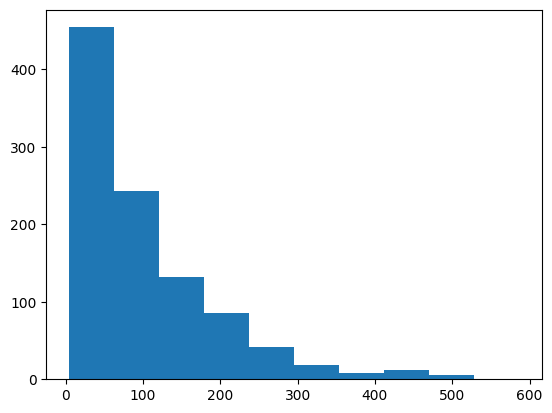

(array([ 11.,  35., 110., 112., 132., 165., 192., 141.,  76.,  26.]),
 array([1.60943791, 2.08616682, 2.56289572, 3.03962462, 3.51635353,
        3.99308243, 4.46981133, 4.94654024, 5.42326914, 5.89999804,
        6.37672695]),
 <BarContainer object of 10 artists>)

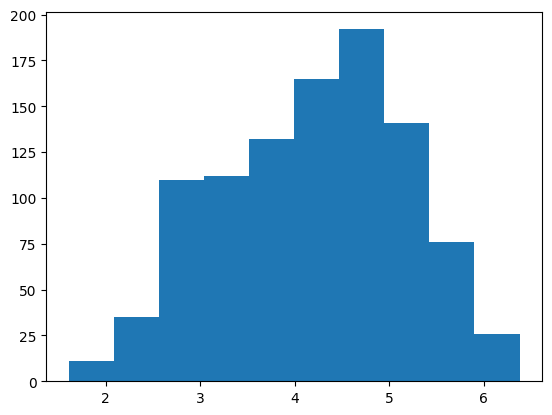

In [ ]:
plt.hist(pm25.pm25)
plt.show()

plt.hist(np.log(pm25.pm25 + 1))

Explore some other relationships. No major issues with outliers or weird shapes. Also no strong trends encountered.

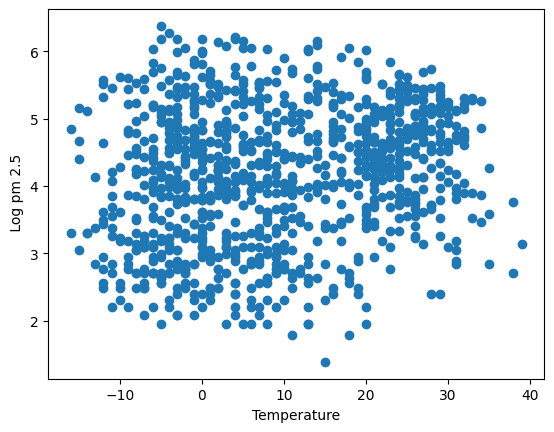

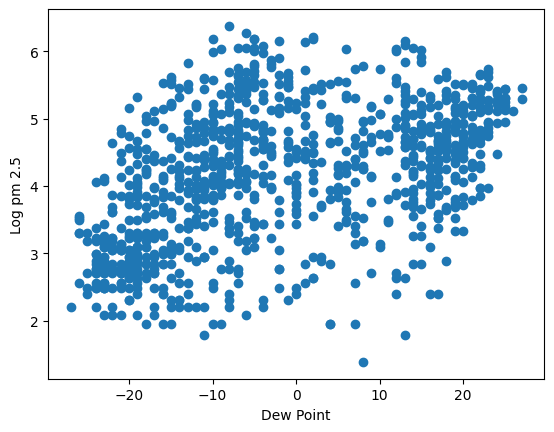

In [ ]:
plt.scatter(pm25.TEMP,np.log(pm25.pm25))
plt.xlabel("Temperature")
plt.ylabel(" Log pm 2.5")
plt.show()

plt.scatter(pm25.DEWP,np.log(pm25.pm25))
plt.xlabel("Dew Point")
plt.ylabel("Log pm 2.5")
plt.show()

Build a decision tree with max depth of 3.

[Text(0.5, 0.875, 'DEWP <= -13.5\nsquared_error = 1.006\nsamples = 800\nvalue = 4.155'),
 Text(0.25, 0.625, 'Iws <= 9.17\nsquared_error = 0.722\nsamples = 218\nvalue = 3.378'),
 Text(0.125, 0.375, 'DEWP <= -16.5\nsquared_error = 0.811\nsamples = 84\nvalue = 3.95'),
 Text(0.0625, 0.125, 'squared_error = 0.624\nsamples = 54\nvalue = 3.729'),
 Text(0.1875, 0.125, 'squared_error = 0.902\nsamples = 30\nvalue = 4.348'),
 Text(0.375, 0.375, 'cbwd_SE <= 0.5\nsquared_error = 0.332\nsamples = 134\nvalue = 3.019'),
 Text(0.3125, 0.125, 'squared_error = 0.264\nsamples = 127\nvalue = 2.962'),
 Text(0.4375, 0.125, 'squared_error = 0.454\nsamples = 7\nvalue = 4.048'),
 Text(0.75, 0.625, 'Iws <= 108.855\nsquared_error = 0.802\nsamples = 582\nvalue = 4.446'),
 Text(0.625, 0.375, 'Iws <= 3.125\nsquared_error = 0.71\nsamples = 551\nvalue = 4.514'),
 Text(0.5625, 0.125, 'squared_error = 0.588\nsamples = 237\nvalue = 4.778'),
 Text(0.6875, 0.125, 'squared_error = 0.71\nsamples = 314\nvalue = 4.315'),
 Text

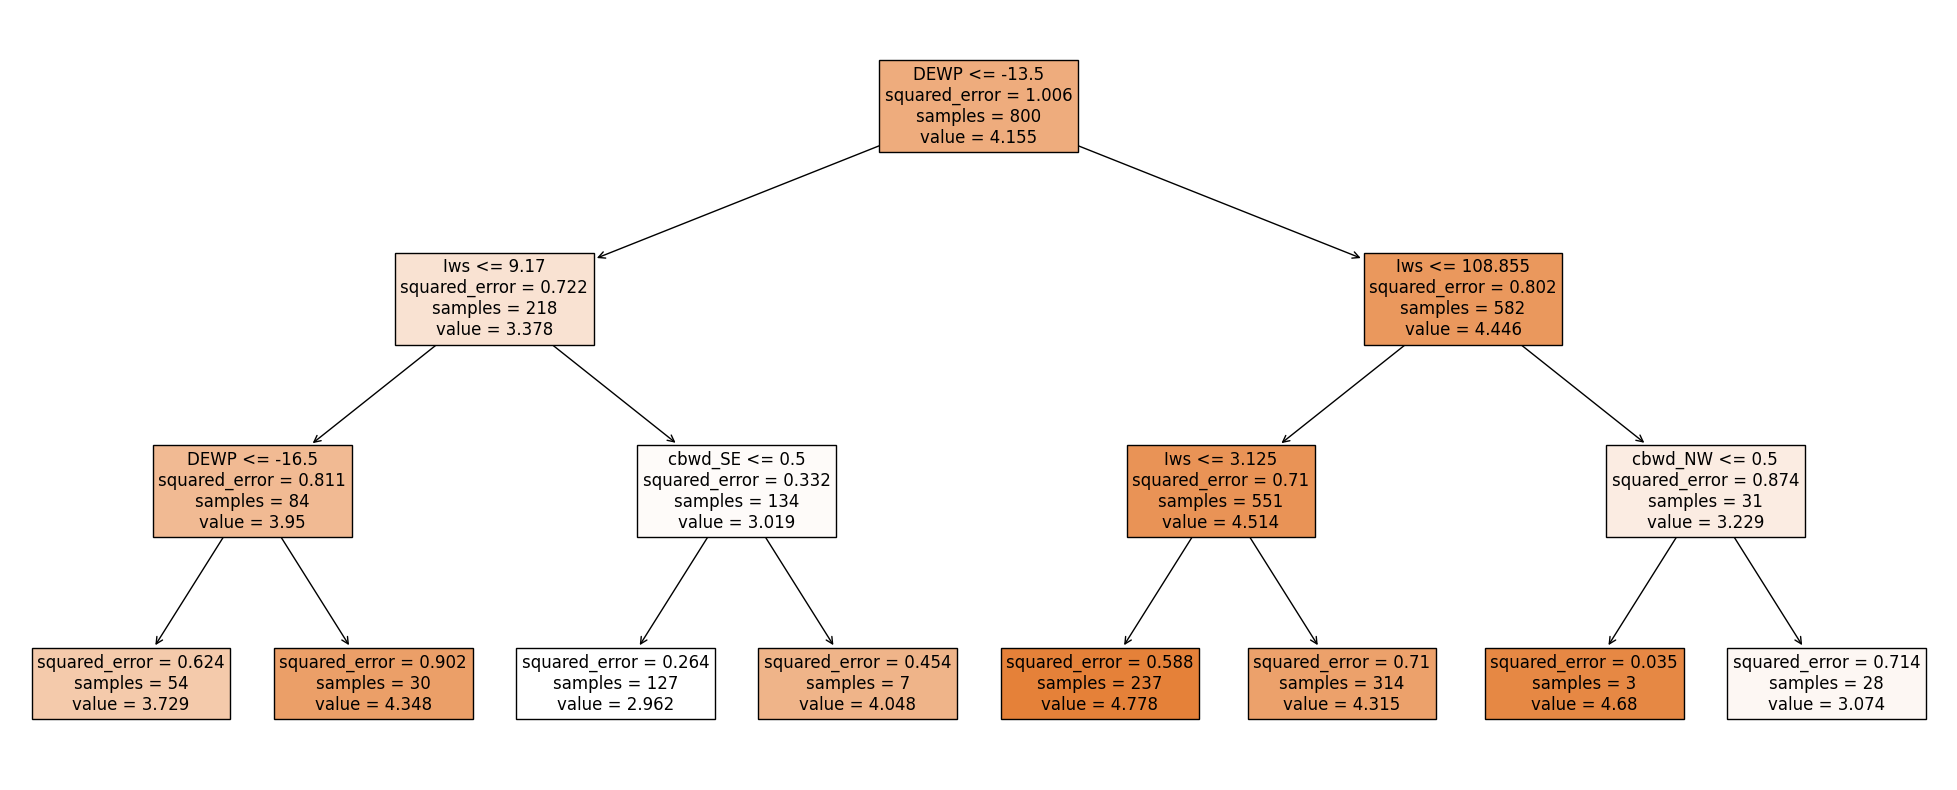

In [ ]:
# Remove the target. Also remove the day variable, doesn't seem like it should be useful
pm25_predictors = pm25.drop(columns = ["pm25","day"])

# Dummify
X = pd.get_dummies(pm25_predictors,drop_first = True)

y = np.log(pm25["pm25"])

# split into train/test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)



tree_prep = DecisionTreeRegressor(max_depth = 3)
mod_tree = tree_prep.fit(X_train,y_train)
plt.figure(figsize = (25,10))
tree.plot_tree(mod_tree, feature_names=X.columns, filled = True,fontsize = 12)



Find the R^2. I actually am not bothering to transform back to non-log scale. If all your models are on the log scale, you don't need to transform back to compare.

In [ ]:

preds = mod_tree.predict(X_test)
r2_score(y_test,preds)


0.2939299905404895

What if we don't set a max depth?

In [ ]:
tree_prep = DecisionTreeRegressor()
mod_tree = tree_prep.fit(X_train,y_train)
preds = mod_tree.predict(X_test)
print("In Sample R^2: ",r2_score(y_train,mod_tree.predict(X_train)))
print("Out Of Sample R^2: ",r2_score(y_test,preds))

In Sample R^2:  1.0
Out Of Sample R^2:  0.22851831535236544


Perform cost complexity tuning using alpha = 0.001. This is like the LASSO for trees!

In [ ]:
tree_prep = DecisionTreeRegressor(ccp_alpha = 0.1)
mod_tree = tree_prep.fit(X_train,y_train)
preds = mod_tree.predict(X_test)
print("In Sample R^2: ",r2_score(y_train,mod_tree.predict(X_train)))
print("Out Of Sample R^2: ",r2_score(y_test,preds))

In Sample R^2:  0.22465259816344896
Out Of Sample R^2:  0.21062228967291596


Let's explore many possible alphas to use.

In [ ]:
tree_prep = DecisionTreeRegressor()
# This code gives a bunch of possible alphas that can be used
path = mod_tree.cost_complexity_pruning_path(X_train,y_train)

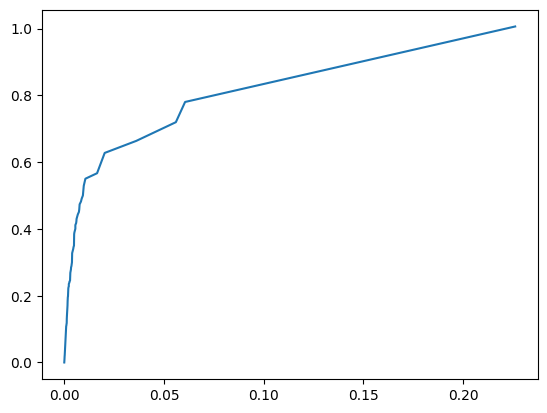

In [ ]:
# The path object has a ccp_alphas attribute that contains possible alphas
# and the impurities attribute contains relative MSE of the training set
ccp_alphas, MSEs = path.ccp_alphas, path.impurities
plt.plot(ccp_alphas,MSEs)

This is the reason why I reduced the data size. We are going to test every single possible alpha. This may take a while for larger data sets.

In [ ]:
# Create empty vectors to collect in sample and out of sample R^2 values
R2_in = []
R2_out = R2_in.copy()

# Do a loop testing different alphas and calculating in sample and out of sample R^2 values
for ccp_alpha in path.ccp_alphas:
    tree_temp = DecisionTreeRegressor(ccp_alpha=ccp_alpha)
    tree_temp.fit(X_train, y_train)
    R2_in.append(r2_score(y_train,tree_temp.predict(X_train)))
    R2_out.append(r2_score(y_test,tree_temp.predict(X_test)))




Plot the in sample and out of sample R^2 values by alpha. Note that we should see the iout of sample R^2 peak. If we don't maybe we should try some more different alphas.

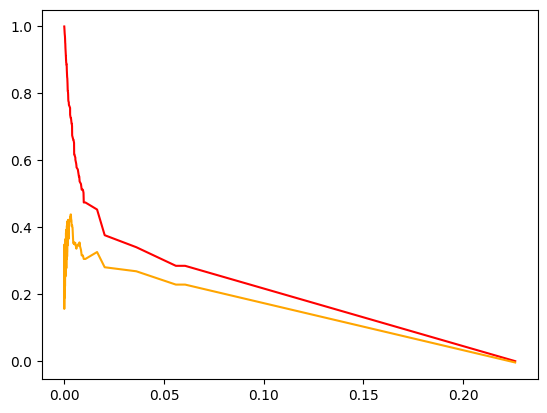

In [ ]:
grid = path.ccp_alphas
plt.plot(grid,R2_in,color="r")
plt.plot(grid,R2_out,color = "orange")
plt.show()

In [ ]:
print(ccp_alphas)

[0.00000000e+00 2.22044605e-18 4.44089210e-18 4.44089210e-18
 8.88178420e-18 8.88178420e-18 1.77635684e-17 2.66453526e-17
 1.61866428e-08 1.61866428e-08 1.89726920e-08 3.50688518e-08
 5.11872019e-08 6.31307817e-08 7.46528642e-08 9.76587932e-08
 9.95371522e-08 1.22259353e-07 1.52594100e-07 1.60006827e-07
 1.67973124e-07 1.89045447e-07 1.99309062e-07 2.02916588e-07
 2.45090030e-07 2.65721878e-07 2.77028774e-07 2.87074377e-07
 2.91576019e-07 2.98629292e-07 3.01920213e-07 3.10966761e-07
 3.15643281e-07 3.58598597e-07 3.59459144e-07 3.62932495e-07
 4.69189867e-07 4.95998943e-07 5.56999631e-07 5.91809361e-07
 5.91809361e-07 5.91809361e-07 6.71982800e-07 6.71982800e-07
 6.71982800e-07 6.83150581e-07 6.86918031e-07 7.18322004e-07
 7.18322004e-07 7.21813908e-07 7.97363390e-07 8.26628464e-07
 8.41868955e-07 8.57534880e-07 8.68223044e-07 8.90207723e-07
 9.36758408e-07 9.44981104e-07 1.01034670e-06 1.04152202e-06
 1.06315119e-06 1.10836075e-06 1.13207549e-06 1.20966524e-06
 1.23497450e-06 1.244176

Let's find the alpha that gives us the best out of sample performance.

In [ ]:
# Pair each alpha with its corresponding R^2 value
paired_values = zip(R2_out, path.ccp_alphas)

# Find the pair with the maximum R^2 value
max_R2, best_alpha = max(paired_values)

#best_alpha = path.ccp_alphas[np.argmax(R2_out)]

# Print the alpha that gives the largest R^2
print("Alpha for the largest R^2:", best_alpha)
print("The best R^2 value was:", max_R2)

Alpha for the largest R^2: 0.0033321538618047864
The best R^2 value was: 0.43830275086751547


A Random Forest is a really neat way to use decision trees to build models.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print("In Sample R^2: ",r2_score(y_train,regressor.predict(X_train)))
print("Out Of Sample R^2: ",r2_score(y_test,y_pred))

In Sample R^2:  0.93848499068955
Out Of Sample R^2:  0.5291002744285467


We can set the ccp of the individual trees.

In [ ]:
regressor = RandomForestRegressor(n_estimators=1000, random_state=0,ccp_alpha = 0.001)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print("In Sample R^2: ",r2_score(y_train,regressor.predict(X_train)))
print("Out Of Sample R^2: ",r2_score(y_test,y_pred))

In Sample R^2:  0.8915142608937177
Out Of Sample R^2:  0.5571576543070303


We can even play around with max depth.

In [ ]:
regressor = RandomForestRegressor(n_estimators=1000, random_state=0,max_depth = 8)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print("In Sample R^2: ",r2_score(y_train,regressor.predict(X_train)))
print("Out Of Sample R^2: ",r2_score(y_test,y_pred))

In Sample R^2:  0.8084406309825464
Out Of Sample R^2:  0.5289937035169263


In [ ]:
regressor.feature_importances_
dict(zip(X.columns,regressor.feature_importances_))

{'year': 0.031215000447758913,
 'hour': 0.04926725715886925,
 'DEWP': 0.32556843764097754,
 'TEMP': 0.16460565006975453,
 'PRES': 0.05479096616948956,
 'Iws': 0.17571371078620532,
 'Is': 0.0005434534229759441,
 'Ir': 0.007641829581490804,
 'month_Aug': 0.008655642885493439,
 'month_Dec': 0.0030916879432323595,
 'month_Feb': 0.006567383684112183,
 'month_Jan': 0.005942964444446713,
 'month_Jul': 0.00537273525878657,
 'month_Jun': 0.005577542963213731,
 'month_Mar': 0.015077345284060892,
 'month_May': 0.009281878487685158,
 'month_Nov': 0.008494141917483246,
 'month_Oct': 0.017327240407002318,
 'month_Sep': 0.013563932966822893,
 'cbwd_NW': 0.07418735161658371,
 'cbwd_SE': 0.014297582667842751,
 'cbwd_cv': 0.0032162641957121647}

<Axes: >

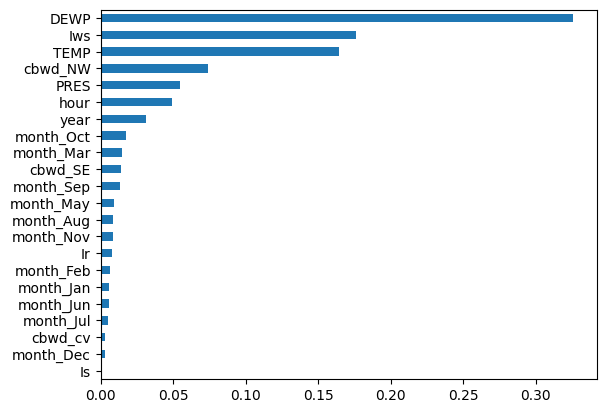

In [ ]:
pd.Series(regressor.feature_importances_, index=X.columns).sort_values().plot(kind='barh')